In [1]:
# import modules and utilize GPU is available
import json
import numpy as np
import pandas as pd
from collections import OrderedDict
import torch
import torchvision
from torch import nn, optim
from torchvision import transforms, models, datasets
from torchsummary import summary
from IPython.display import Image
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset
from PIL import Image
import PIL.ImageOps
from src.custom_dataset import catdataset
from src.nn_trainer import trainer
import os.path
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
%matplotlib inline

In [4]:
# initialize densenet
classes = ['cat', 'pig']
densenet = models.densenet121(pretrained=True)
# define extra layer for densenet
extra_layer = nn.Sequential(OrderedDict([('layer1', nn.Linear(1024, 500)),
                                         ('relu1', nn.ReLU()),
                                         ('layer2', nn.Linear(500, 1))]))
densenet.classifier = extra_layer
densenet.to(device)
# check if model is trained already, if yes then load the model and if not train the model
if os.path.exists('saved_model/full_trained.pt'):
    densenet.load_state_dict(torch.load('saved_model/full_trained.pt', map_location = device))
    densenet.eval()
else:
    # load dataset
    dataset = catdataset(transform = transforms.Compose([transforms.ToPILImage(),transforms.Resize((64,64)),
                                       transforms.ToTensor()]) )
    # split dataset into training and test set
    train_set, test_set = torch.utils.data.random_split(dataset, [int(dataset.length*0.8),
                                                              dataset.length - int(dataset.length*0.8)])
    # create data loader
    train_loader = torch.utils.data.DataLoader(dataset = train_set, batch_size = 256, shuffle = True)
    test_loader = torch.utils.data.DataLoader(dataset = test_set, batch_size = 256, shuffle = True)
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(densenet.parameters())
    results = trainer(densenet, criterion, optimizer, train_loader, test_loader, epochs = 10)
    densenet.eval()
    torch.save(densenet.state_dict(), 'saved_model/')

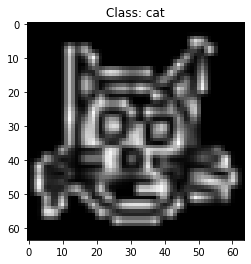

In [61]:
# Show an example
X, y = next(iter(train_loader))
plt.imshow(X[1, 0, :, :], cmap="gray")
plt.title(f"Class: {classes[y[1].item()]}");

In [5]:
im_frame = Image.open('pauline2.png').convert('RGB')
# invert image
im_frame = PIL.ImageOps.invert(im_frame)
im_frame = transforms.Resize((64,64))(im_frame)
im_frame = transforms.ToTensor()(im_frame)
pauline2 = im_frame.unsqueeze(0).to(device)
prediction = int(torch.sigmoid(densenet(pauline2)) > 0.5)
print(classes[prediction])
print(f"The prediction is {classes[prediction]} with probability of {float(torch.sigmoid(densenet(pauline2))) if classes[prediction] is 'pig' else float(1-torch.sigmoid(densenet(pauline2)))}")

pig
The prediction is pig with probability of 0.9764650464057922
